# 1. Import libraries to be used in this notebook

In [1]:
import numpy as np # for array manipulation and basic scientific calculation
import xarray as xr # To read NetCDF files
import matplotlib.pyplot as plt # Core library for plotting
from functions.Calc_Emis import Calc_Emis_T # Emission calculation
from scipy.interpolate import griddata # Simple regridding
from functions.ZonalMeridional import SE_ZonalMeridional # To calculate zonal/meridional mean

# 2. Read files

## 2.1. Model output

In [5]:
Filebase_nanjing = '/glade/campaign/acom/acom-weather/emmons/tutorial_nanjing/f.e3beta01.FCnudged.Nanjing_ne30x8.02/atm/hist/f.e3beta01.FCnudged.Nanjing_ne30x8.02.cam.h1a.2024-03-DD-00000.nc'
# Change "DD" to 01~31 for a month calculation
Files_nanjing = [] # empty list for a start
# file list with 31 files
for dd in np.arange(31):
    Files_nanjing.append( Filebase_nanjing.replace('DD',str(dd+1).zfill(2)) )
# read 31 files at once using "mf"dataset
ds_nanjing = xr.open_mfdataset( Files_nanjing ) 


In [7]:
ds_nanjing

<xarray.Dataset> Size: 4GB
Dimensions:       (time: 31, ncol: 60482, lev: 32, ilev: 33, nbnd: 2)
Coordinates:
  * lev           (lev) float64 256B 3.643 7.595 14.36 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 264B 2.255 5.032 10.16 ... 967.5 985.1 1e+03
  * time          (time) datetime64[ns] 248B 2024-02-29T12:00:00 ... 2024-03-...
Dimensions without coordinates: ncol, nbnd
Data variables: (12/56)
    lat           (time, ncol) float64 15MB dask.array<chunksize=(1, 60482), meta=np.ndarray>
    lon           (time, ncol) float64 15MB dask.array<chunksize=(1, 60482), meta=np.ndarray>
    areawt        (time, ncol) float64 15MB dask.array<chunksize=(1, 60482), meta=np.ndarray>
    area          (time, ncol) float64 15MB dask.array<chunksize=(1, 60482), meta=np.ndarray>
    hyam          (time, lev) float64 8kB dask.array<chunksize=(1, 32), meta=np.ndarray>
    hybm          (time, lev) float64 8kB dask.array<chunksize=(1, 32), meta=np.ndarray>
    ...            ...
    bc_a4         (time, lev, ncol) float32 240MB dask.array<chunksize=(1, 32, 60482), meta=np.ndarray>
    pom_a1        (time, lev, ncol) float32 240MB dask.array<chunksize=(1, 32, 60482), meta=np.ndarray>
    pom_a4        (time, lev, ncol) float32 240MB dask.array<chunksize=(1, 32, 60482), meta=np.ndarray>
    so4_a1        (time, lev, ncol) float32 240MB dask.array<chunksize=(1, 32, 60482), meta=np.ndarray>
    so4_a2        (time, lev, ncol) float32 240MB dask.array<chunksize=(1, 32, 60482), meta=np.ndarray>
    so4_a3        (time, lev, ncol) float32 240MB dask.array<chunksize=(1, 32, 60482), meta=np.ndarray>
Attributes:
    ne:                0
    np:                4
    Conventions:       CF-1.0
    source:            CAM
    case:              f.e3beta01.FCnudged.Nanjing_ne30x8.02
    logname:           emmons
    host:              dec0355
    initial_file:      /glade/work/emmons/tutorial_Nanjing/ne0np4.Nanjing.ne3...
    topography_file:   /glade/work/emmons/tutorial_Nanjing/ne0np4.Nanjing.ne3...
    model_doi_url:     not_set
    time_period_freq:  day_1

## 2.2. SCRIP file
### SCRIP file has grid information that is needed to calculate area of each grid
### Don't have to read, just locate where the files are

In [6]:
SCRIP_nanjing = '/glade/work/emmons/tutorial_Nanjing/ne0np4.Nanjing.ne30x8/grids/Nanjing_ne30x8_np4_SCRIP.nc'

# 3. Emission total

## 3.1. Calculate emissions for 31 days

In [8]:
ds_nanjing['SFCO']

<xarray.DataArray 'SFCO' (time: 31, ncol: 60482)> Size: 7MB
dask.array<concatenate, shape=(31, 60482), dtype=float32, chunksize=(1, 60482), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 248B 2024-02-29T12:00:00 ... 2024-03-30T12...
Dimensions without coordinates: ncol
Attributes:
    units:         kg/m2/s
    long_name:     CO surface flux
    cell_methods:  time: mean

In [13]:
# Calculate CO emissions - global
CO_Emis_global = Calc_Emis_T( ds_nanjing['SFCO'], print_results=False, 
                              mw=28., scrip_file=SCRIP_nanjing )
# Calculate CO emissions - specify longitudes and latitudes
CO_Emis_nanjing = Calc_Emis_T( ds_nanjing['SFCO'], print_results=False, 
                             mw=28., scrip_file=SCRIP_nanjing, 
                             lon_range=[80,150], lat_range=[10,55] )


## 3.2 Draw a simple plot

Text(0.5, 1.0, 'Global CO emissions in March, 2024')

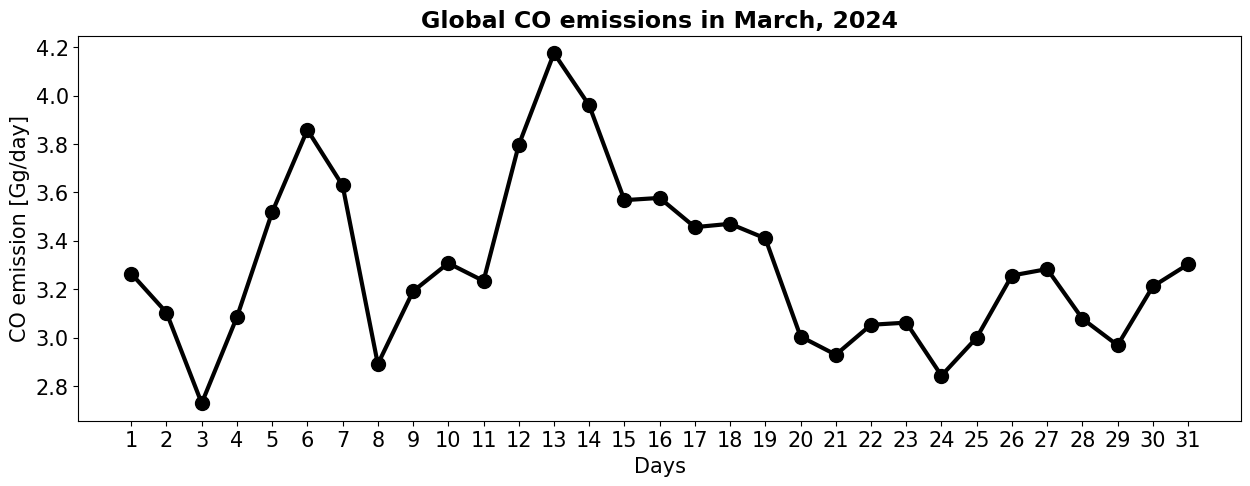

In [28]:
fig = plt.figure( figsize=(15,5) )
ax = fig.add_subplot(1,1,1)

# Plot global daily CO emissions
ax.plot( np.arange(31)+1, CO_Emis_global.emissions_total/1E9, 'ko-', lw=3, ms=10 )

# === Polish the plot === 
# Font size
ax.set_xticks( np.arange(31)+1 )
plt.setp( ax.get_xticklabels(), fontsize=15 )
plt.setp( ax.get_yticklabels(), fontsize=15 )
# Add x & y axis titles
ax.set_xlabel( 'Days', fontsize=15 )
ax.set_ylabel( 'CO emission [Gg/day]', fontsize=15 )
# Add a plot title
ax.set_title( 'Global CO emissions in March, 2024', fontsize=17, weight='semibold' )



# 4. Vertical profile

## 4.1. Calculate vertical profile of ozone over the region of interest

In [35]:
ds_nanjing

<xarray.Dataset> Size: 4GB
Dimensions:       (time: 31, ncol: 60482, lev: 32, ilev: 33, nbnd: 2)
Coordinates:
  * lev           (lev) float64 256B 3.643 7.595 14.36 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 264B 2.255 5.032 10.16 ... 967.5 985.1 1e+03
  * time          (time) datetime64[ns] 248B 2024-02-29T12:00:00 ... 2024-03-...
Dimensions without coordinates: ncol, nbnd
Data variables: (12/56)
    lat           (time, ncol) float64 15MB dask.array<chunksize=(1, 60482), meta=np.ndarray>
    lon           (time, ncol) float64 15MB dask.array<chunksize=(1, 60482), meta=np.ndarray>
    areawt        (time, ncol) float64 15MB dask.array<chunksize=(1, 60482), meta=np.ndarray>
    area          (time, ncol) float64 15MB dask.array<chunksize=(1, 60482), meta=np.ndarray>
    hyam          (time, lev) float64 8kB dask.array<chunksize=(1, 32), meta=np.ndarray>
    hybm          (time, lev) float64 8kB dask.array<chunksize=(1, 32), meta=np.ndarray>
    ...            ...
    bc_a4         (time, lev, ncol) float32 240MB dask.array<chunksize=(1, 32, 60482), meta=np.ndarray>
    pom_a1        (time, lev, ncol) float32 240MB dask.array<chunksize=(1, 32, 60482), meta=np.ndarray>
    pom_a4        (time, lev, ncol) float32 240MB dask.array<chunksize=(1, 32, 60482), meta=np.ndarray>
    so4_a1        (time, lev, ncol) float32 240MB dask.array<chunksize=(1, 32, 60482), meta=np.ndarray>
    so4_a2        (time, lev, ncol) float32 240MB dask.array<chunksize=(1, 32, 60482), meta=np.ndarray>
    so4_a3        (time, lev, ncol) float32 240MB dask.array<chunksize=(1, 32, 60482), meta=np.ndarray>
Attributes:
    ne:                0
    np:                4
    Conventions:       CF-1.0
    source:            CAM
    case:              f.e3beta01.FCnudged.Nanjing_ne30x8.02
    logname:           emmons
    host:              dec0355
    initial_file:      /glade/work/emmons/tutorial_Nanjing/ne0np4.Nanjing.ne3...
    topography_file:   /glade/work/emmons/tutorial_Nanjing/ne0np4.Nanjing.ne3...
    model_doi_url:     not_set
    time_period_freq:  day_1

In [41]:
# Get the first timestep using the isel function of xarray
# You can use it for any dimensions such as altitude
ds_nanjing_dep = ds_nanjing.isel(time=1)


# Nanjing region
# Longitude in MUSICAv0 (CESM) is from 0 to 360
lon_range = [117, 120]; lat_range=[31,34]


# Get longitude & latitude
lon = ds_nanjing_dep['lon'].values
lat = ds_nanjing_dep['lat'].values

# Get array indices for Nanjing, based on center longitude and latitude
Indices = np.where( ( lon >= lon_range[0] ) & ( lon <= lon_range[1] ) \
                  & ( lat >= lat_range[0] ) & ( lat <= lat_range[1] ) )[0]

# Calculate mean ozone profile
# The first dimension is altitude, the second is ncol
# Use np.mean to average it over the whole Nanjing region
O3_profile = np.mean( ds_nanjing_dep['O3'].values[:,Indices], 1 ) * 1e9


# Also get geopotential height for y-axis
Z3_profile = np.mean( ds_nanjing_dep['Z3'].values[:,Indices], 1 ) / 1e3


In [42]:
ds_nanjing_dep

<xarray.Dataset> Size: 131MB
Dimensions:       (ncol: 60482, lev: 32, ilev: 33, nbnd: 2)
Coordinates:
  * lev           (lev) float64 256B 3.643 7.595 14.36 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 264B 2.255 5.032 10.16 ... 967.5 985.1 1e+03
    time          datetime64[ns] 8B 2024-03-01T12:00:00
Dimensions without coordinates: ncol, nbnd
Data variables: (12/56)
    lat           (ncol) float64 484kB dask.array<chunksize=(60482,), meta=np.ndarray>
    lon           (ncol) float64 484kB dask.array<chunksize=(60482,), meta=np.ndarray>
    areawt        (ncol) float64 484kB dask.array<chunksize=(60482,), meta=np.ndarray>
    area          (ncol) float64 484kB dask.array<chunksize=(60482,), meta=np.ndarray>
    hyam          (lev) float64 256B dask.array<chunksize=(32,), meta=np.ndarray>
    hybm          (lev) float64 256B dask.array<chunksize=(32,), meta=np.ndarray>
    ...            ...
    bc_a4         (lev, ncol) float32 8MB dask.array<chunksize=(32, 60482), meta=np.ndarray>
    pom_a1        (lev, ncol) float32 8MB dask.array<chunksize=(32, 60482), meta=np.ndarray>
    pom_a4        (lev, ncol) float32 8MB dask.array<chunksize=(32, 60482), meta=np.ndarray>
    so4_a1        (lev, ncol) float32 8MB dask.array<chunksize=(32, 60482), meta=np.ndarray>
    so4_a2        (lev, ncol) float32 8MB dask.array<chunksize=(32, 60482), meta=np.ndarray>
    so4_a3        (lev, ncol) float32 8MB dask.array<chunksize=(32, 60482), meta=np.ndarray>
Attributes:
    ne:                0
    np:                4
    Conventions:       CF-1.0
    source:            CAM
    case:              f.e3beta01.FCnudged.Nanjing_ne30x8.02
    logname:           emmons
    host:              dec0355
    initial_file:      /glade/work/emmons/tutorial_Nanjing/ne0np4.Nanjing.ne3...
    topography_file:   /glade/work/emmons/tutorial_Nanjing/ne0np4.Nanjing.ne3...
    model_doi_url:     not_set
    time_period_freq:  day_1

## 4.2. Plot vertical profile

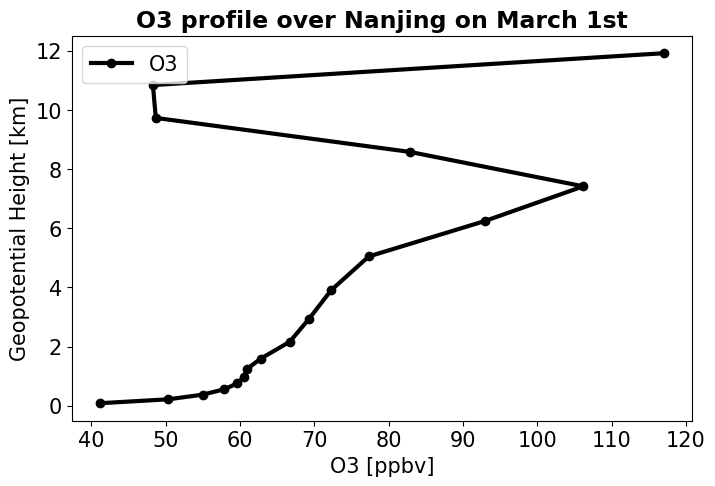

In [43]:
fig = plt.figure( figsize=(8,5) )
ax = fig.add_subplot(1,1,1)

# Plot O3 profile
ax.plot( O3_profile[14:], Z3_profile[14:], 'ko-', lw=3, label='O3' )

# === Polish the plot === 
# Font size
plt.setp( ax.get_xticklabels(), fontsize=15 )
plt.setp( ax.get_yticklabels(), fontsize=15 )
# Add x & y axis titles
ax.set_xlabel( 'O3 [ppbv]', fontsize=15 )
ax.set_ylabel( 'Geopotential Height [km]', fontsize=15 )
# Add a plot title
ax.set_title( 'O3 profile over Nanjing on March 1st', fontsize=17, weight='semibold' )

# Add a legend
ax.legend( fontsize=15, loc=0 )


# 5. Cross section

## 5.1. Regrid data to a traditional lat/lon grid

### This example uses griddata function by Scipy library. 
### For advanced regridding methods, use ESMPy (https://earthsystemmodeling.org/esmpy_doc/release/latest/html/intro.html)

In [44]:
# This will define the lat/lon range we are using to correspond to global 1x1 grid
x = np.linspace(0.5,359.5,360)
y = np.linspace(-89.5,89.5,180)
# This will put lat and lon into arrays, something that is needed for plotting
X, Y = np.meshgrid(x,y)

# Here we are putting the unstructured data onto our defined 1x1 grid using linear interpolation
Regridded_O3 = griddata( (lon,lat), ds_nanjing_dep['DF_O3'].values, (X, Y), method='linear')
Regridded_HNO3 = griddata( (lon,lat), ds_nanjing_dep['WD_HNO3'].values, (X, Y), method='linear')

# Make zonal-mean
# use nanmean instead of mean to deal with nan values around the pole
# DF_O3 and WD_HNO3 are in kg/m2/s. 8.64e7 is used to convert kg/m2/s to kg/m2/day
Zmean_O3 = np.nanmean( Regridded_O3, 1 ) * 8.64e7
Zmean_HNO3 = np.nanmean( Regridded_HNO3, 1 ) * 8.64e7

In [55]:
Zmean_O3.shape

(180,)

## 5.2. Plot meridional cross section

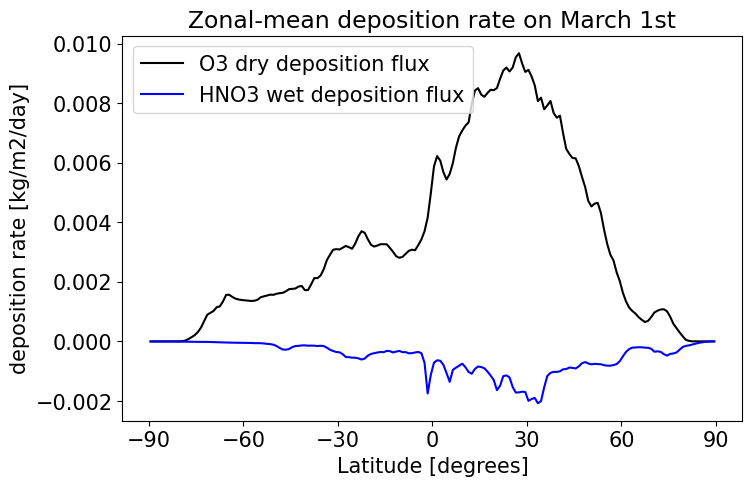

In [46]:
fig = plt.figure( figsize=(8,5) )
ax = fig.add_subplot(1,1,1)

# Plot global 
ax.plot( y, Zmean_O3, 'k-', label='O3 dry deposition flux' )
ax.plot( y, Zmean_HNO3, 'b-', label='HNO3 wet deposition flux' )

# === Polish the plot === 
# Set x-axis ticks
ax.set_xticks( [-90,-60,-30,0,30,60,90] )
# Font size
plt.setp( ax.get_xticklabels(), fontsize=15 )
plt.setp( ax.get_yticklabels(), fontsize=15 )
# Add x & y axis titles
ax.set_xlabel( 'Latitude [degrees]', fontsize=15 )
ax.set_ylabel( 'deposition rate [kg/m2/day]', fontsize=15 )
# Add a plot title
ax.set_title( 'Zonal-mean deposition rate on March 1st', fontsize=17 )

# Add a legend
ax.legend( fontsize=15, loc=0 )

## 5.3. Another way to calculate cross section
### This example uses a function that calculates area-weighted zonal/meridional cross section

In [49]:
# Regrid the data for zonal plot to a regular grid with the following resolution
Regridding_res=1.  #in degree

# Get area information
area= ds_nanjing_dep['area'].values

DF_O3 = ds_nanjing_dep['DF_O3'].values* 8.64e7
WD_HNO3 = ds_nanjing_dep['WD_HNO3'].values* 8.64e7

Zmean_DF_O3,Z_coord=SE_ZonalMeridional(DF_O3,area,lat,Regridding_res) 
Zmean_WD_HNO3,Z_coord=SE_ZonalMeridional(WD_HNO3,area,lat,Regridding_res)


## 5.4. Same as 5.2 but with different regridding method used in 5.3

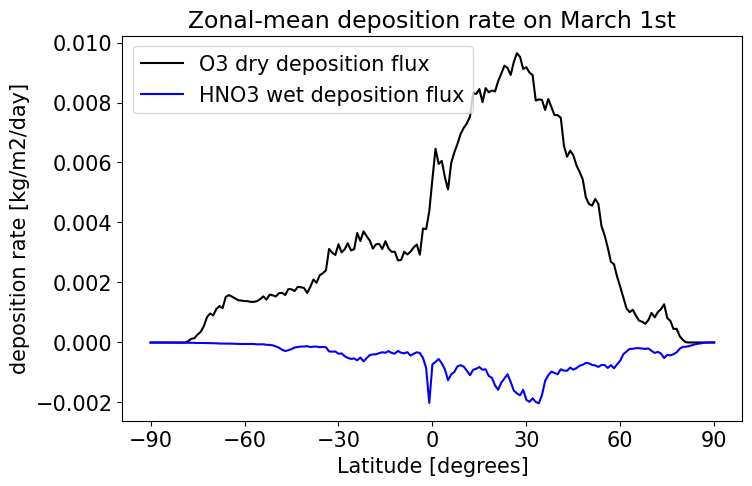

In [56]:
fig = plt.figure( figsize=(8,5) )
ax = fig.add_subplot(1,1,1)

# Plot global 
ax.plot( Z_coord, Zmean_DF_O3, 'k-', label='O3 dry deposition flux' )
ax.plot( Z_coord, Zmean_WD_HNO3, 'b-', label='HNO3 wet deposition flux' )

# === Polish the plot === 
# Set x-axis ticks
ax.set_xticks( [-90,-60,-30,0,30,60,90] )
# Font size
plt.setp( ax.get_xticklabels(), fontsize=15 )
plt.setp( ax.get_yticklabels(), fontsize=15 )
# Add x & y axis titles
ax.set_xlabel( 'Latitude [degrees]', fontsize=15 )
ax.set_ylabel( 'deposition rate [kg/m2/day]', fontsize=15 )
# Add a plot title
ax.set_title( 'Zonal-mean deposition rate on March 1st', fontsize=17 )

# Add a legend
ax.legend( fontsize=15, loc=0 )